<a href="https://colab.research.google.com/github/abhash896/Bangalore-home-price-prediction/blob/main/Feed_forward_neural_network_and_GPUs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks on a GPU with PyTorch

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
# Downloading the training dataset if it is not already present
dataset = MNIST(root = 'data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
len(dataset)

60000

In [4]:
dataset[0][0].shape

torch.Size([1, 28, 28])

The images are converted to pytorch tensors with the shape 1x28x28 (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects the channels to be the last dimension in an image tensor unlike what we have here. So, we can use the `permute` method to reorder the dimensions of the image.

In [5]:
image, label = dataset[0]

In [6]:
image.shape

torch.Size([1, 28, 28])

In [7]:
image.permute(1, 2, 0).shape

torch.Size([28, 28, 1])

image.shape:  torch.Size([1, 28, 28])
Label:  5


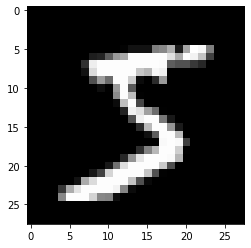

In [8]:
print('image.shape: ', image.shape)
plt.imshow(image[0], cmap = 'gray')
print('Label: ', label)

In [9]:
image.shape

torch.Size([1, 28, 28])

In [10]:
image[0].shape

torch.Size([28, 28])

Let's use the random_split helper function to set aside 10000 images for our validation set.

In [11]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create Pytorch data loader for training and validation.

In [12]:
batch_size = 128

In [13]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. we'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`. What make_grid does is it takes a batch of images and converts them into a single image by putting them in a grid. we need to specify how many images need to be put into each row.

In [14]:
for i, _ in train_loader:
  print(i.shape)
  break

torch.Size([128, 1, 28, 28])


images.shape:  torch.Size([128, 1, 28, 28])


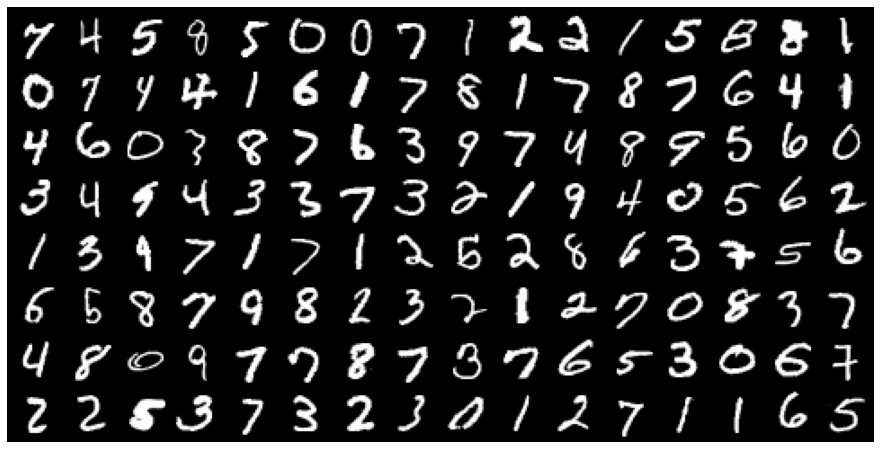

In [15]:
for images, _ in train_loader:
  print('images.shape: ', images.shape)
  plt.figure(figsize = (16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16).permute((1,2,0)))
  break

# Hidden layers, Activation functions and non-linearity

We will create a neural network with two layers: a hidden layer and an output layer. Additionally, we will use an activation function between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We will flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [16]:
for images, labels in train_loader:
  print('images.shape: ', images.shape)
  inputs = images.reshape(-1, 784)
  print('inputs.shape: ', inputs.shape)
  break

images.shape:  torch.Size([128, 1, 28, 28])
inputs.shape:  torch.Size([128, 784])


In [17]:
input_size = inputs.shape[-1]
hidden_size = 32

In [18]:
layer1 = nn.Linear(input_size, hidden_size)

In [19]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape: ', layer1_outputs.shape)

layer1_outputs.shape:  torch.Size([128, 32])


`torch.allclose` method is used to compare two tensors on values. 

In [20]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias

In [21]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Adding a relu activation function to add non-linearity to the model.

In [22]:
relu_outputs = F.relu(layer1_outputs)

In [23]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [24]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [25]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3387, grad_fn=<NllLossBackward0>)

A deep neural network is simply a neural network with one or more hidden layers. In fact, the universal approximation theorem states that a sufficiently large and deep neural network can compute any arbitrary function i.e., it can can learn rich and complex non-linear relationships between inputs and targets.

In [26]:
class MnistModel(nn.Module):
  '''Feedforward neural network with 1 hidden layer'''
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    '''We get a batch of images from training data_loader. we flatten those images such that the images can be passed to the layers as input.'''
    # Flatten the image tensors
    xb = xb.reshape(-1, 784)
    # or xb = xb.view(xb.size(0), -1)
    # Get intermediate outputs using hidden layer
    out = self.linear1(xb)
    # Applying activation function
    out = F.relu(out)
    # Get predictions using output layer
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    """Returns the loss for a batch of training data"""
    images, labels = batch
    out = self(images)                      # Generate predictions
    loss = F.cross_entropy(out, labels)     # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                      # Generate predictions
    loss = F.cross_entropy(out, labels)     # calculate loss
    acc = accuracy(out, labels)             # calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()          # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f'Epoch [{epoch}], val_loss: {result["val_loss"]}, val_acc: {result["val_acc"]}')




In [27]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed uining `torch.cuda.is_available`.

In [28]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't.

This should always be done. Never write your code assuming that there is a GPU present because there will be circumstances where you might have to run it without a GPU.

`torch.device` method return a pointer to the device present.

In [29]:
def get_default_device():
  '''Pick GPU if avaialble, else CPU'''
  if torch.cuda.is_available():
    return torch.device('cuda')

  else:
    return torch.devide('cpu')

In [30]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

The data can be a tensor or a model.
Both tensors and models in pytorch have a `.to` method that takes the target device as input and transfers the data to the target device.

In [31]:
def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [32]:
isinstance(2, (list))

False

In [33]:
images.device

device(type='cpu')

In [34]:
for images, labels in train_loader:
  print(images.shape)
  print(images.device)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cpu
cuda:0


This has to be done manually as we get new batch of data, we move it to the GPU.

Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a pytorch data loader. All we need is an `__iter__` method to retrieve batches of data and a `__len__` method to get the number of batches.

In [35]:
class DeviceDataLoader():
  '''Wrap a data_loader to move data to a device'''
  def __init__(self, data_loader, device):
    self.data_loader = data_loader
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to a device'''
    for b in self.data_loader:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.data_loader)

The `yield` keyword in python is used to create a generator function that can be used within a `for` loop.

In [37]:
def some_number():
  yield 10
  yield 20
  yield 30

for value in some_number():
  print(value)

10
20
30


We can wrap our data loaders using DeviceDataLoader.

In [39]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [40]:
for xb, yb in val_loader:
  print('xb.device: ', xb.device)
  print('yb: ', yb)
  break

xb.device:  cuda:0
yb:  tensor([5, 6, 0, 9, 5, 8, 9, 7, 5, 6, 4, 9, 0, 2, 4, 1, 3, 8, 5, 9, 3, 9, 9, 6,
        4, 3, 1, 9, 4, 6, 6, 9, 3, 9, 2, 5, 0, 3, 8, 8, 2, 8, 2, 9, 0, 8, 0, 0,
        2, 8, 9, 3, 6, 3, 3, 4, 4, 3, 6, 6, 7, 5, 8, 5, 9, 1, 0, 9, 9, 2, 1, 1,
        6, 1, 1, 3, 8, 8, 7, 6, 7, 6, 6, 9, 7, 4, 8, 1, 0, 0, 4, 9, 6, 9, 1, 3,
        0, 5, 0, 1, 5, 3, 5, 1, 6, 0, 2, 3, 5, 3, 9, 9, 2, 6, 9, 3, 8, 7, 7, 7,
        4, 2, 2, 5, 1, 1, 6, 2, 0, 9, 6, 6, 1, 4, 6, 0, 7, 0, 8, 6, 7, 6, 5, 3,
        1, 5, 0, 9, 0, 3, 9, 3, 7, 4, 1, 9, 7, 0, 0, 2, 2, 6, 8, 6, 1, 7, 8, 6,
        0, 0, 5, 3, 9, 1, 3, 6, 2, 7, 5, 3, 8, 7, 1, 8, 2, 1, 2, 6, 3, 1, 2, 6,
        5, 0, 9, 5, 1, 7, 5, 0, 1, 5, 2, 0, 0, 8, 9, 3, 2, 1, 9, 8, 4, 1, 3, 5,
        9, 1, 1, 5, 1, 6, 2, 9, 4, 4, 8, 6, 1, 0, 0, 5, 8, 0, 1, 5, 9, 1, 4, 2,
        2, 3, 7, 9, 9, 0, 2, 9, 4, 0, 5, 8, 8, 3, 8, 6], device='cuda:0')


# Training the model

We will define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.

In [41]:
def evaluate(model, val_loader):
  '''Evaluate the model's performance on the validation set.'''
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [53]:
# Defining a function to train the model.

def fit(epochs, lr, model, train_loader, val_loader, opt_funct = torch.optim.SGD):
  '''Train the model using gradient descent.'''
  optimizer = opt_funct(model.parameters(), lr)
  log = []

  for epoch in range(epochs):
    # Training phase
    for batch in train_loader:
      loss = model.training_step(batch) # yet to define the training_step function.
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation phase
    result = evaluate(model, val_loader) # not yet defined.
    model.epoch_end(epoch, result)
    log.append(result)

  return log



Before we train the model, we need to ensure that the data and the model's parameters(weights and biases) are on the same device(CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device.

In [43]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size = hidden_size, out_size = output_size)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [51]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.318781614303589, 'val_acc': 0.07167968899011612}]

Let's train the model for some epochs and look at the results. We can use a relatively high learning rate of 0.5.

In [54]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.23908987641334534, val_acc: 0.9278320074081421
Epoch [1], val_loss: 0.18544325232505798, val_acc: 0.9452148675918579
Epoch [2], val_loss: 0.16068875789642334, val_acc: 0.95068359375
Epoch [3], val_loss: 0.14437413215637207, val_acc: 0.9561523199081421
Epoch [4], val_loss: 0.19405613839626312, val_acc: 0.9405273199081421
Epoch [5], val_loss: 0.13713808357715607, val_acc: 0.9574218988418579
Epoch [6], val_loss: 0.13805964589118958, val_acc: 0.9585937261581421
Epoch [7], val_loss: 0.13165383040905, val_acc: 0.9619140625
Epoch [8], val_loss: 0.13059523701667786, val_acc: 0.9608398675918579
Epoch [9], val_loss: 0.12985678017139435, val_acc: 0.9618164300918579


In [59]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.11697429418563843, val_acc: 0.965527355670929
Epoch [1], val_loss: 0.11625206470489502, val_acc: 0.9671875238418579
Epoch [2], val_loss: 0.11568637937307358, val_acc: 0.9668945074081421
Epoch [3], val_loss: 0.11853762716054916, val_acc: 0.966503918170929
Epoch [4], val_loss: 0.11688083410263062, val_acc: 0.9657226800918579


We can now plot the losses and accuracies to study how the model improves over time.

Text(0.5, 1.0, 'Loss vs No. of epochs')

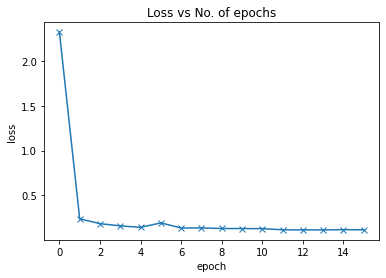

In [60]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No. of epochs')

Text(0.5, 1.0, 'Accuracy vs No. of epochs')

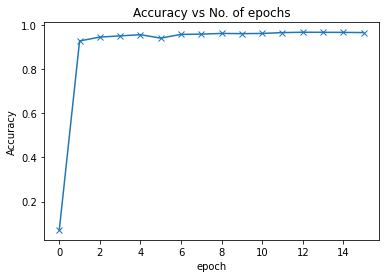

In [61]:
losses = [x['val_acc'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs No. of epochs')

# Testing with individual images

In [62]:
# Define test dataset
test_dataset = MNIST(root = 'data/', train = False, transform = ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [67]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  return preds[0].item()

Label:  7 , Predicted:  7


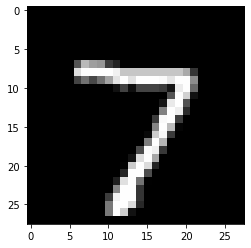

In [68]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print('Label: ', label, ', Predicted: ', predict_image(img, model))

In [69]:
def predict_image_demo(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  return preds[0].item()

Since the data and the model are not on the same device, we get an error.

RuntimeError: ignored

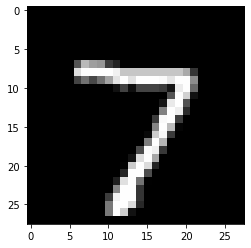

In [70]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print('Label: ', label, ', Predicted: ', predict_image_demo(img, model))

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [71]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size = 256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.09758587926626205, 'val_acc': 0.9715820550918579}

# Saving the model

In [72]:
torch.save(model.state_dict(), 'mnist_feedforward.pth')